In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load and Prepare Data

# Load data (Ensure this CSV exists in your working directory)
data = pd.read_csv('customer_churn_dataset-testing-master.csv')

# Clean the column names
data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")

# Handle missing values
data = data.dropna()

# Create tenure_months
data['tenure_months'] = data['tenure']

# Separate features and target
Y = data['churn']
X = data.drop(['churn'], axis=1)

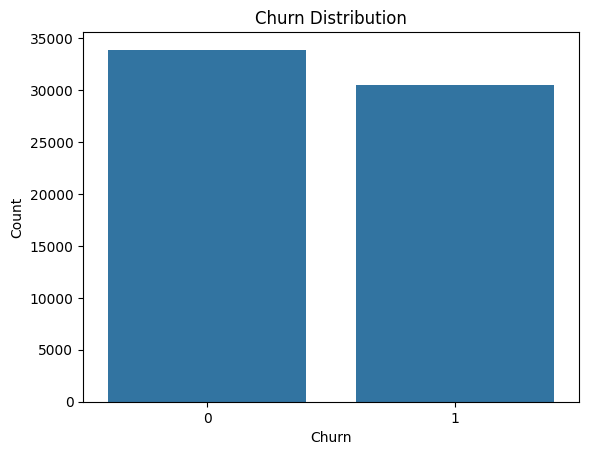

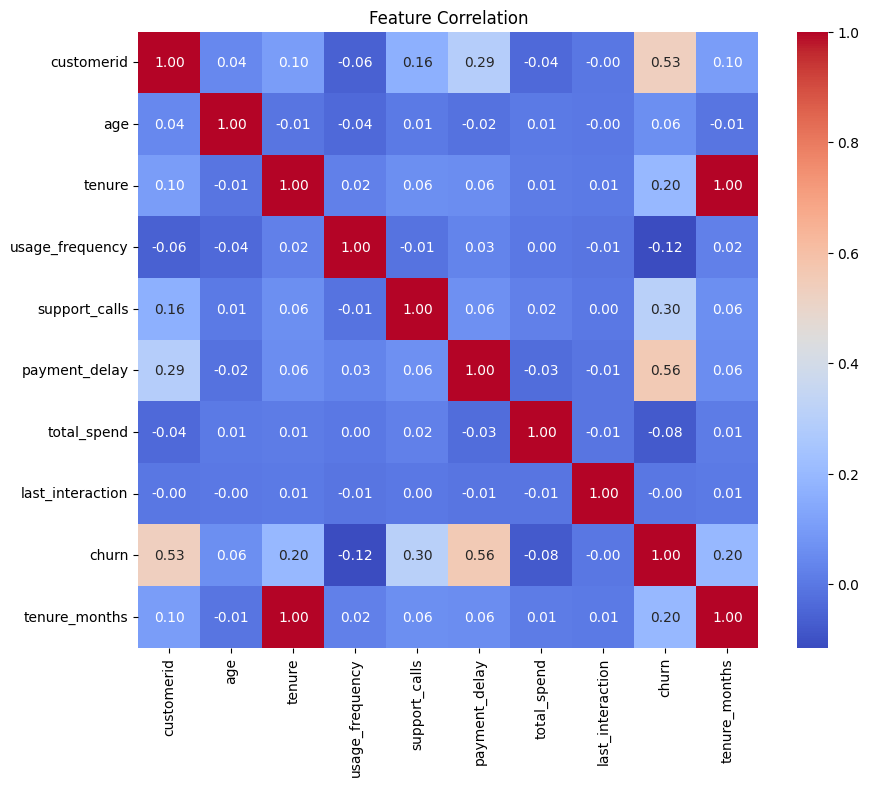

In [10]:
# Exploratory Analysis
# Visualize churn distribution
sns.countplot(x='churn', data=data)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

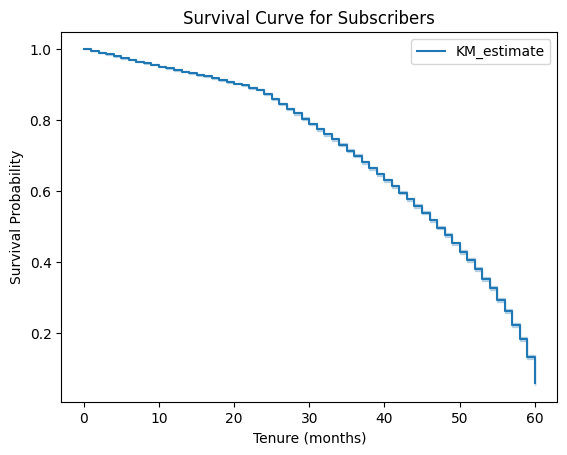

In [11]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Ensure no nulls (use correct column names after lowercase transformation)
data = data.dropna(subset=['tenure', 'churn'])  # Ensure these match cleaned column names

# Recalculate tenure_months in case it was dropped
data['tenure_months'] = data['tenure']  # 'tenure' is now lowercase

# Fit and plot Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(durations=data['tenure_months'], event_observed=data['churn'])
kmf.plot()

plt.title('Survival Curve for Subscribers')
plt.ylabel('Survival Probability')
plt.xlabel('Tenure (months)')
plt.show()

In [16]:
# Machine Learning Model

# One-hot encode categorical columns
categorical_columns = ['subscription_type', 'contract_length']  # Add any other categorical columns here
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)  # drop_first avoids collinearity

# Select features
features_selected = ['tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend'] + \
    [col for col in data.columns if col.startswith('subscription_type') or col.startswith('contract_length')]

# Select the feature set (X) and target variable (y)
X = data[features_selected]
y = data['churn']  # 'churn' is correctly lowercase

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Brier Score:", brier_score_loss(y_test, y_prob))

# Feature importances (for logistic regression, we look at coefficients)
feature_importances = pd.DataFrame(model.coef_[0], index=features_selected, columns=['Importance'])
print("Feature Importances:\n", feature_importances.sort_values(by='Importance', ascending=False))


AUC-ROC Score: 0.8960576231998498
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      6793
           1       0.80      0.82      0.81      6082

    accuracy                           0.82     12875
   macro avg       0.82      0.82      0.82     12875
weighted avg       0.82      0.82      0.82     12875

Brier Score: 0.1292265669188258
Feature Importances:
                             Importance
payment_delay                 1.779404
support_calls                 0.935839
tenure                        0.541538
contract_length_Monthly       0.171518
subscription_type_Standard   -0.038033
subscription_type_Premium    -0.038996
contract_length_Quarterly    -0.068748
total_spend                  -0.264289
usage_frequency              -0.496673


In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers for logistic regression
}

# Initialize the model
log_reg = LogisticRegression(max_iter=10000)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and model from grid search
print("Best parameters:", grid_search.best_params_)
print("Best AUC-ROC Score from Grid Search:", grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluate performance of the best model
print("AUC-ROC Score (Best Model):", roc_auc_score(y_test, y_prob))
print("Classification Report (Best Model):\n", classification_report(y_test, y_pred))
print("Brier Score (Best Model):", brier_score_loss(y_test, y_prob))


Best parameters: {'C': 0.01, 'solver': 'liblinear'}
Best AUC-ROC Score from Grid Search: 0.8893218193481008
AUC-ROC Score (Best Model): 0.8960785598924711
Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      6793
           1       0.80      0.82      0.81      6082

    accuracy                           0.82     12875
   macro avg       0.82      0.82      0.82     12875
weighted avg       0.82      0.82      0.82     12875

Brier Score (Best Model): 0.12941232755774126


In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Random Forest AUC-ROC Score:", roc_auc_score(y_test, y_prob_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Brier Score:", brier_score_loss(y_test, y_prob_rf))


Random Forest AUC-ROC Score: 0.9792004487665094
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      6793
           1       0.88      0.96      0.92      6082

    accuracy                           0.92     12875
   macro avg       0.92      0.92      0.92     12875
weighted avg       0.92      0.92      0.92     12875

Random Forest Brier Score: 0.05273140194174757


In [20]:
from xgboost import XGBClassifier

# Initialize the model
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("XGBoost AUC-ROC Score:", roc_auc_score(y_test, y_prob_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Brier Score:", brier_score_loss(y_test, y_prob_xgb))


XGBoost AUC-ROC Score: 0.9801817382373181
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      6793
           1       0.88      0.96      0.92      6082

    accuracy                           0.92     12875
   macro avg       0.92      0.92      0.92     12875
weighted avg       0.92      0.92      0.92     12875

XGBoost Brier Score: 0.052286417786887904


In [21]:
# Feature importances for Random Forest
rf_feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance'])
print("Random Forest Feature Importances:\n", rf_feature_importances.sort_values(by='Importance', ascending=False))

# Feature importances for XGBoost
xgb_feature_importances = pd.DataFrame(xgb_model.feature_importances_, index=X.columns, columns=['Importance'])
print("XGBoost Feature Importances:\n", xgb_feature_importances.sort_values(by='Importance', ascending=False))

Random Forest Feature Importances:
                             Importance
payment_delay                 0.450797
support_calls                 0.159011
tenure                        0.137646
usage_frequency               0.104535
total_spend                   0.099582
contract_length_Monthly       0.026782
contract_length_Quarterly     0.008953
subscription_type_Standard    0.006475
subscription_type_Premium     0.006220
XGBoost Feature Importances:
                             Importance
payment_delay                 0.382132
contract_length_Monthly       0.191697
support_calls                 0.153692
usage_frequency               0.107768
tenure                        0.084791
total_spend                   0.026108
contract_length_Quarterly     0.026041
subscription_type_Standard    0.015493
subscription_type_Premium     0.012278
